In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_bar, facet_grid, labs, theme, element_text, position_stack, position_dodge, scale_fill_manual, geom_errorbar
)

In [3]:
def mean_cl(data, col):
    data = data[col]
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci_low = mean - 1.96 * std_err
    ci_upp = mean + 1.96 * std_err
    return {f'{col}_mean': mean, f'{col}_lwr': ci_low, f'{col}_upr': ci_upp}

def make_acc_df(results):    
    results['prob_other'] = 1 - (results['lf0_prob'] + results['lf1_prob'] + results['prob_invalid'])

    return results.groupby(['n_samples', 'lf0_proportion', 'n_shots']).apply(
        lambda x: pd.Series({
            **mean_cl(x, 'lf0_prob'),
            **mean_cl(x, 'lf1_prob'),
            **mean_cl(x, 'prob_invalid'),
            **mean_cl(x, 'prob_other')
        })
    ).reset_index()

In [47]:
def make_long_accs_df(accs):
    ground_truth = pd.DataFrame()

    for n_samples in accs['n_samples'].unique():
        for lf0_proportion in accs['lf0_proportion'].unique():
            for n_shots in accs['n_shots'].unique():
                ground_truth = pd.concat([ground_truth, pd.DataFrame({
                    'n_samples': [n_samples],
                    'lf0_proportion': [lf0_proportion],
                    'n_shots': [n_shots],
                    'lf0_prob_mean': [lf0_proportion],
                    'lf1_prob_mean': [1 - lf0_proportion],
                    'prob_invalid_mean': [0],
                    'prob_other_mean': [0],
                    'lf0_prob_lwr': [lf0_proportion],
                    'lf1_prob_lwr': [1 - lf0_proportion],
                    'prob_invalid_lwr': [0],
                    'prob_other_lwr': [0],
                    'lf0_prob_upr': [lf0_proportion],
                    'lf1_prob_upr': [1 - lf0_proportion],
                    'prob_invalid_upr': [0],
                    'prob_other_upr': [0],
                    'method': ['ground_truth']
                })], ignore_index=True)

    accs = pd.concat([ground_truth, accs], ignore_index=True)

    df_long = pd.melt(accs, 
        id_vars=['n_samples', 'lf0_proportion', 'n_shots', 'method'],
        value_vars=['lf0_prob_mean', 'lf1_prob_mean', 'prob_invalid_mean', 'prob_other_mean'],
        var_name='Semantic value',
        value_name='prob_mean'
    )

    df_long['Semantic value'] = df_long['Semantic value'].map({
        'lf0_prob_mean': 'LF0',
        'lf1_prob_mean': 'LF1',
        'prob_invalid_mean': 'Invalid',
        'prob_other_mean': 'Other'
    })

    df_long['lwr'] = pd.melt(
        accs,
        id_vars=['n_samples', 'lf0_proportion', 'n_shots', 'method'],
        value_vars=['lf0_prob_lwr', 'lf1_prob_lwr', 'prob_invalid_lwr', 'prob_other_lwr'],
        value_name='lwr'
    )['lwr']

    df_long['upr'] = pd.melt(
        accs,
        id_vars=['n_samples', 'lf0_proportion', 'n_shots', 'method'],
        value_vars=['lf0_prob_upr', 'lf1_prob_upr', 'prob_invalid_upr', 'prob_other_upr'],
        value_name='upr'
    )['upr']

    df_long['Semantic value'] = pd.Categorical(
        df_long['Semantic value'], categories=['LF0', 'LF1', 'Other', 'Invalid'], ordered=True
    )

    df_long['method'] = pd.Categorical(df_long['method'], categories=['ground_truth', 'genparse', 'local', 'unconstrained'], ordered=True)

    return df_long

# 10 particles, ESS = 0.5

In [7]:
baseline_results = pd.read_csv('results_old/baseline_results_new_prompt.csv')
genparse_results = pd.read_csv('results_old/genparse_results_new.csv')
local_results = pd.read_csv('results_old/local_results.csv')

for results in [baseline_results, genparse_results, local_results]:
    results['prob_other'] = 1 - (results['lf0_prob'] + results['lf1_prob'] + results['prob_invalid'])

baseline_accs = make_acc_df(baseline_results)
genparse_accs = make_acc_df(genparse_results)
localpoe_accs = make_acc_df(local_results)

baseline_accs['method'] = 'unconstrained'
genparse_accs['method'] = 'genparse'
localpoe_accs['method'] = 'local'

accs = pd.concat([baseline_accs, genparse_accs, localpoe_accs], ignore_index=True)

/var/tmp/ipykernel_1071986/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/tmp/ipykernel_1071986/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/tmp/ipykernel_1071986/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the 

In [24]:
df_long = make_long_accs_df(accs)

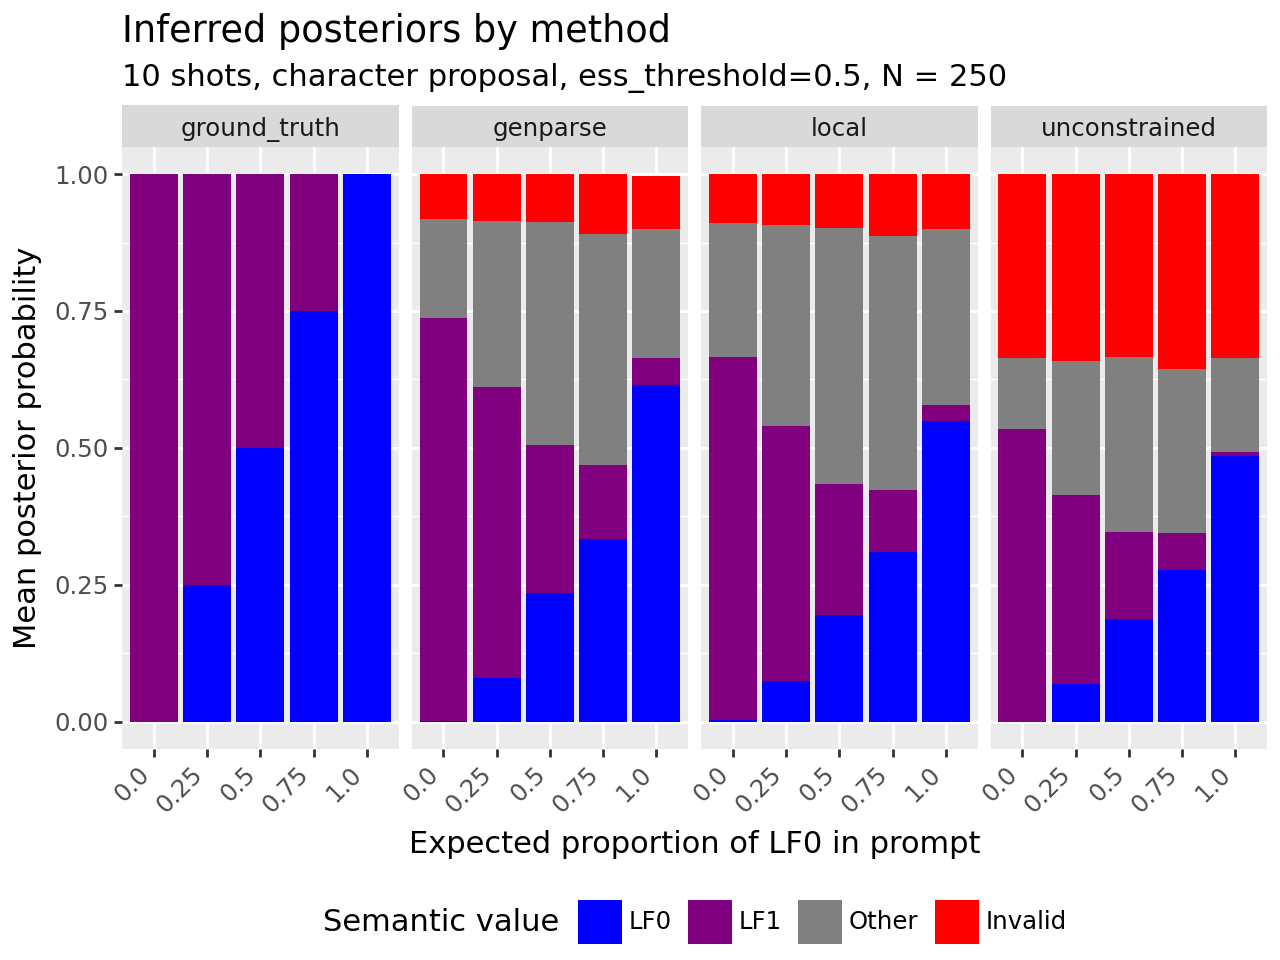

In [37]:
p = (ggplot(df_long, aes(x='factor(lf0_proportion)', y='prob_mean', fill='Semantic value'))
     + geom_bar(stat='identity', position=position_stack(reverse=True))
     + facet_grid('~ method')
     + labs(title='Inferred posteriors by method',
            subtitle='10 shots, character proposal, ess_threshold=0.5, N = 250',
            x='Expected proportion of LF0 in prompt', y='Mean posterior probability')
     + scale_fill_manual(values={
         'LF0': 'blue',
         'LF1': 'purple',
         'Invalid': 'red',
         'Other': 'grey'
     })
     + theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='bottom')
)

p.show()

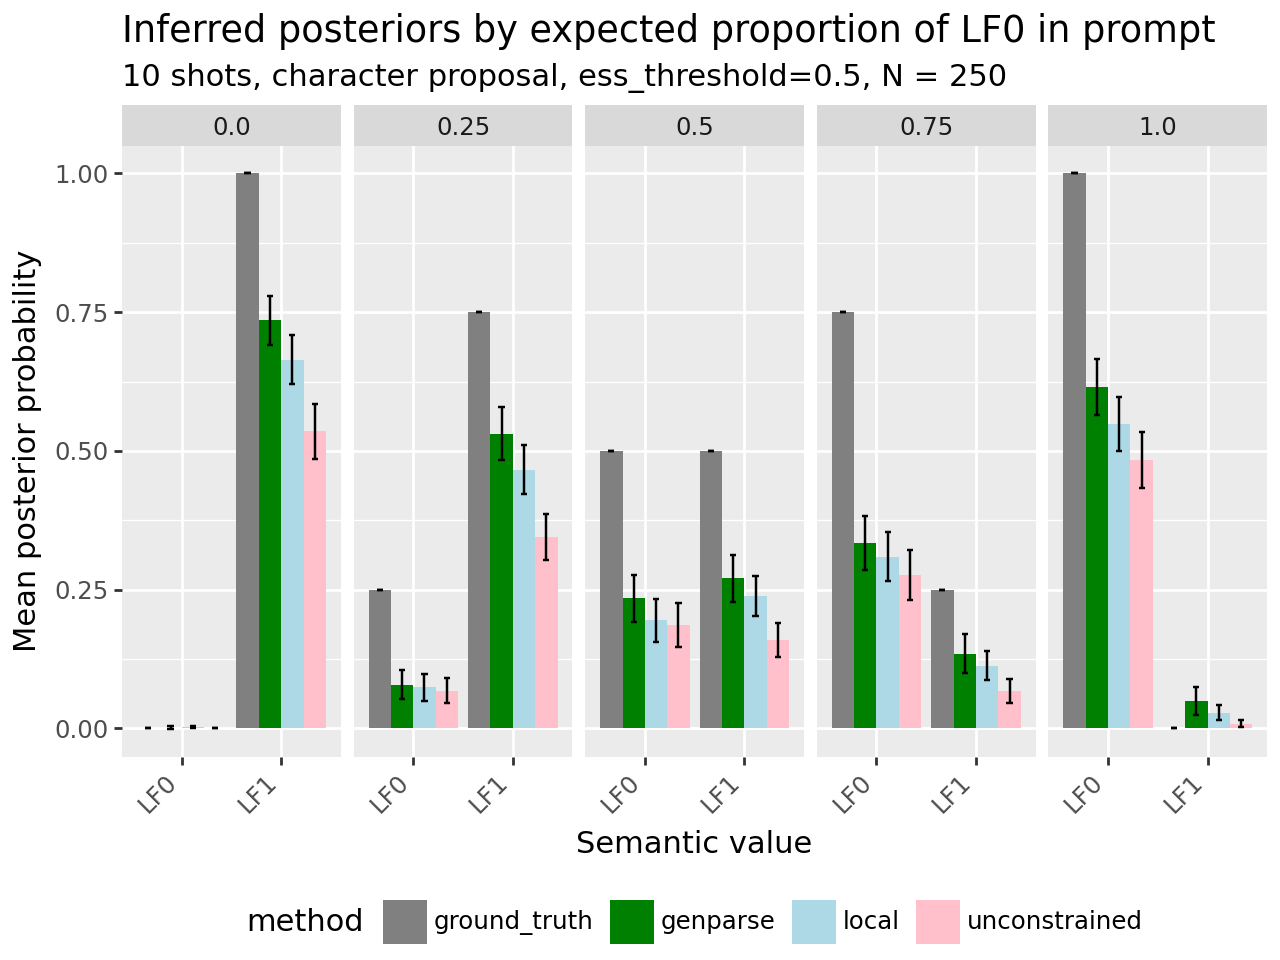

In [45]:
df_long_subset = df_long#[(df_long['method'] != 'unconstrained')]
df_long_subset = df_long_subset[(df_long_subset['Semantic value'] != 'Other') & (df_long_subset['Semantic value'] != 'Invalid')]

dodge_width = 0.9

p = (ggplot(df_long_subset, aes(x='Semantic value', y='prob_mean', fill='method'))
     + geom_bar(stat='identity', position=position_dodge(width=dodge_width))
     + geom_errorbar(aes(ymin='lwr', ymax='upr'), 
                     position=position_dodge(width=dodge_width), 
                     width=0.25)
     + facet_grid('~ lf0_proportion')
     + labs(title='Inferred posteriors by expected proportion of LF0 in prompt',
            subtitle='10 shots, character proposal, ess_threshold=0.5, N = 250',
            x='Semantic value', y='Mean posterior probability')
     + scale_fill_manual(values={
         'genparse': 'green',
         'local': 'lightblue',
         'ground_truth': 'grey',
         'unconstrained': 'pink'
     })
     + theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='bottom')
)

p.show()

# 50 Particles, More instances, ESS = 0.7

In [57]:
baseline_results = pd.read_csv('results/baseline.csv')
genparse_results = pd.read_csv('results/genparse.csv')
local_results = pd.read_csv('results/local.csv')

for results in [baseline_results, genparse_results, local_results]:
    results['prob_other'] = 1 - (results['lf0_prob'] + results['lf1_prob'] + results['prob_invalid'])

baseline_accs = make_acc_df(baseline_results)
genparse_accs = make_acc_df(genparse_results)
localpoe_accs = make_acc_df(local_results)

baseline_accs['method'] = 'unconstrained'
genparse_accs['method'] = 'genparse'
localpoe_accs['method'] = 'local'

accs = pd.concat([baseline_accs, genparse_accs, localpoe_accs], ignore_index=True)

/var/tmp/ipykernel_1071986/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/tmp/ipykernel_1071986/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/tmp/ipykernel_1071986/1533498653.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the 

In [58]:
df_long = make_long_accs_df(accs)

In [79]:
accs.head(5)

,n_samples,lf0_proportion,n_shots,lf0_prob_mean,lf0_prob_lwr,lf0_prob_upr,lf1_prob_mean,lf1_prob_lwr,lf1_prob_upr,prob_invalid_mean,prob_invalid_lwr,prob_invalid_upr,prob_other_mean,prob_other_lwr,prob_other_upr,method
0,10,0.0,10,0.0144,0.008434,0.020366,0.4330,0.400357,0.465643,0.3492,0.319467,0.378933,0.2034,0.181906,0.224894,unconstrained
1,10,0.2,10,0.0530,0.040404,0.065596,0.2668,0.240542,0.293058,0.3676,0.338779,0.396421,0.3126,0.287374,0.337826,unconstrained
2,10,0.5,10,0.1516,0.129814,0.173386,0.1092,0.092915,0.125485,0.3550,0.325442,0.384558,0.3842,0.356893,0.411507,unconstrained
3,10,0.7,10,0.2472,0.220502,0.273898,0.0444,0.035925,0.052875,0.3742,0.344326,0.404074,0.3342,0.308589,0.359811,unconstrained
4,10,1.0,10,0.4262,0.393392,0.459008,0.0014,0.000230,0.002570,0.3596,0.328205,0.390995,0.2128,0.191844,0.233756,unconstrained


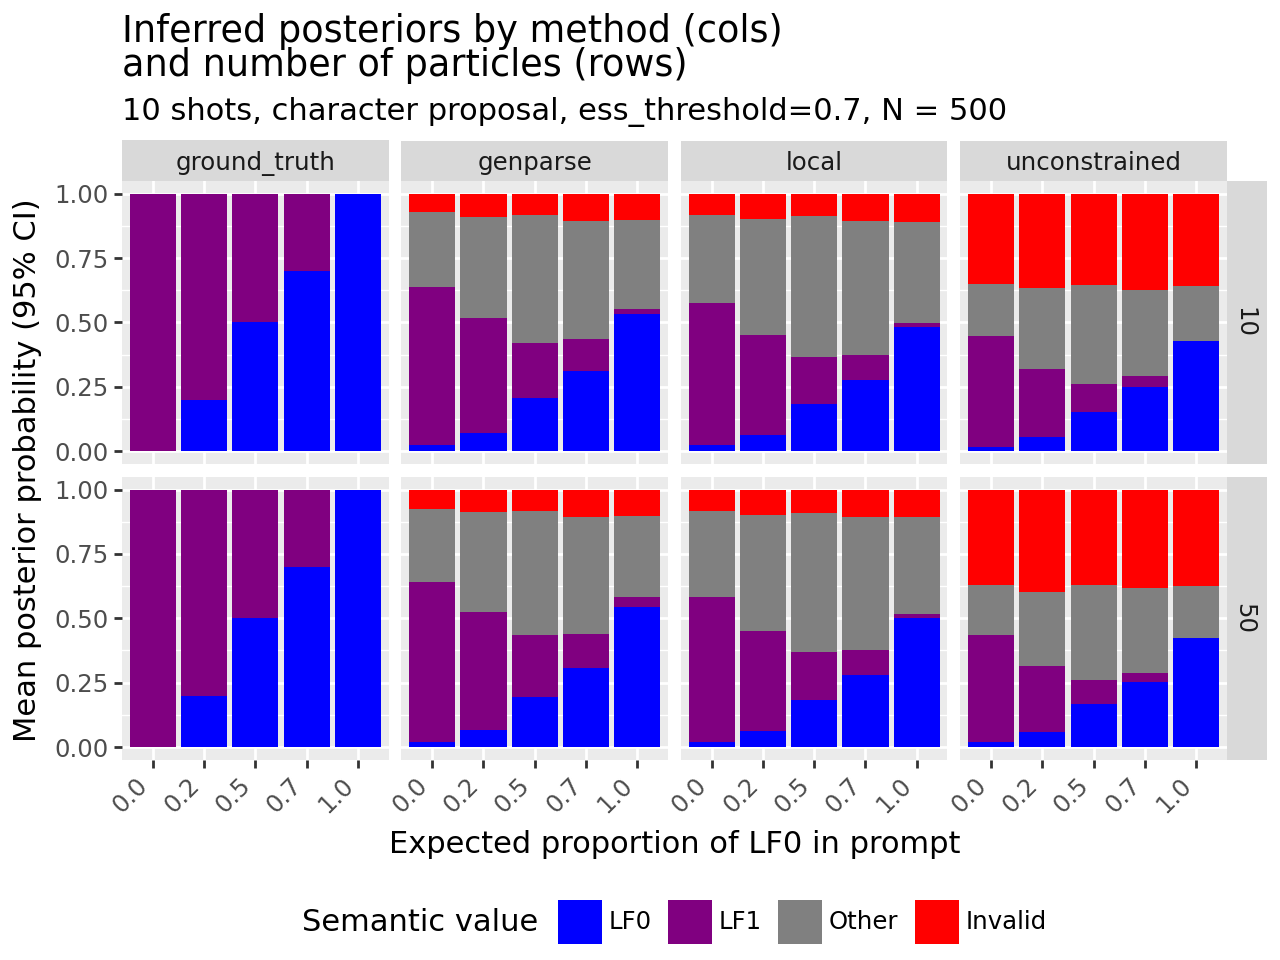

In [75]:
p = (ggplot(df_long, aes(x='factor(lf0_proportion)', y='prob_mean', fill='Semantic value'))
     + geom_bar(stat='identity', position=position_stack(reverse=True))
     + facet_grid('n_samples ~ method')
     + labs(title='Inferred posteriors by method (cols)\nand number of particles (rows)',
            subtitle='10 shots, character proposal, ess_threshold=0.7, N = 500',
            x='Expected proportion of LF0 in prompt', y='Mean posterior probability (95% CI)')
     + scale_fill_manual(values={
         'LF0': 'blue',
         'LF1': 'purple',
         'Invalid': 'red',
         'Other': 'grey'
     })
     + theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='bottom')
)

p.show()

/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/scales/scale_manual.py:44: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 2 values. 4 were requested from it.
/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/scales/scale_manual.py:44: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 2 values. 4 were requested from it.


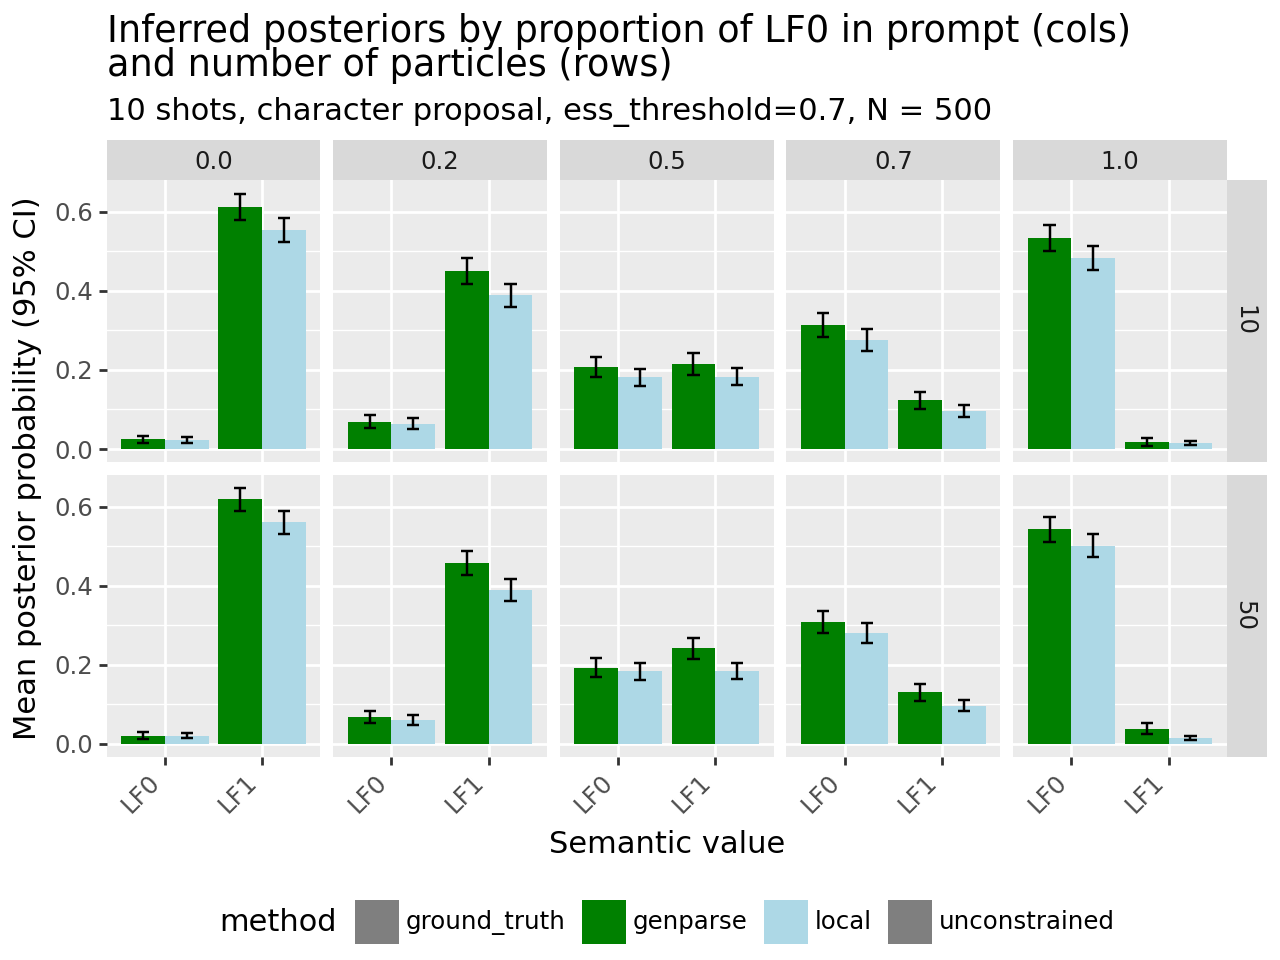

In [76]:
df_long_subset = df_long[(df_long['method'] != 'unconstrained') & (df_long['method'] != 'ground_truth')]
df_long_subset = df_long_subset[(df_long_subset['Semantic value'] != 'Other') & (df_long_subset['Semantic value'] != 'Invalid')]

dodge_width = 0.9

p = (ggplot(df_long_subset, aes(x='Semantic value', y='prob_mean', fill='method'))
     + geom_bar(stat='identity', position=position_dodge(width=dodge_width))
     + geom_errorbar(aes(ymin='lwr', ymax='upr'), 
                     position=position_dodge(width=dodge_width), 
                     width=0.25)
     + facet_grid('n_samples ~ lf0_proportion')
     + labs(title='Inferred posteriors by proportion of LF0 in prompt (cols)\nand number of particles (rows)',
            subtitle='10 shots, character proposal, ess_threshold=0.7, N = 500',
            x='Semantic value', y='Mean posterior probability (95% CI)')
     + scale_fill_manual(values={
         'genparse': 'green',
         'local': 'lightblue'
     })
     + theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='bottom')
)

p.show()